In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

# Paper Code Snippets
Author: Thomas Alexander

Source code for paper "Qiskit Pulse: Programming Quantum Computers Through the Cloud with Pulses" by Thomas Alexander et al.


# Bell circuit snippet

In [3]:
from qiskit import QuantumCircuit, transpile, schedule
from qiskit.test.mock import FakeAlmaden
backend = FakeAlmaden()

#included in paper
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])
qc = transpile(qc, backend)
pulse_schedule = schedule(qc, backend)

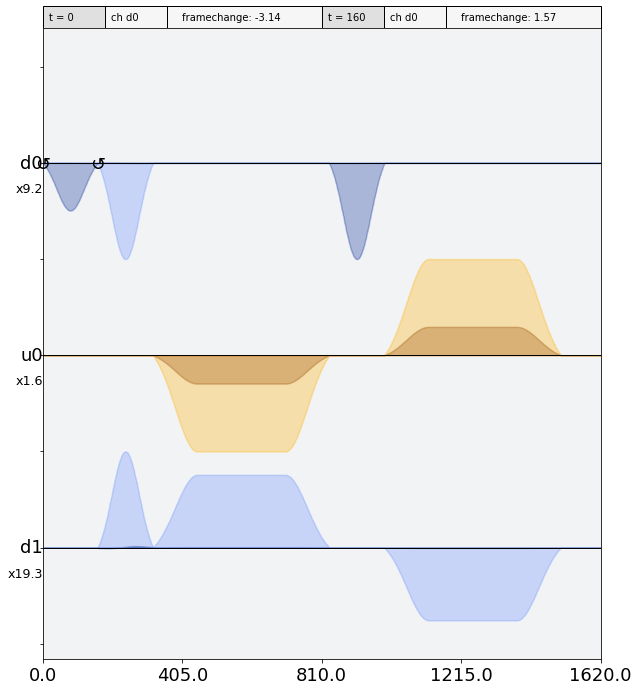

In [4]:
from qiskit.pulse import DriveChannel, ControlChannel
pulse_schedule.filter(channels=[DriveChannel(0),DriveChannel(1), ControlChannel(0)]).draw(plot_range=(0, 1620))

# Manually Constructed Bell State Pulse Schedule

In [5]:
import numpy as np

from qiskit.pulse import (Acquire, AcquireChannel, ControlChannel, Delay, 
                          DriveChannel, MeasureChannel, MemorySlot, Play,
                          Schedule, ShiftPhase)

from qiskit.pulse.pulse_lib import Drag, Gaussian, GaussianSquare

# define pulses with arbitrary parameters for demonstration.
# In practice these must be found with calibration
drag_dur = 160
cr_dur = 512
meas_dur = 16000

cr90_amp = 0.7
meas_amp = 0.6
x90_amp_q0 = 0.3
x90_amp_q1 = 0.3

x90_beta_q0 = 0.05
x90_beta_q1 = 0.05

sigma = 32
constant_width = 48

measure_stimulus = GaussianSquare(meas_dur, meas_amp, sigma, constant_width)
cr90p = GaussianSquare(cr_dur, cr90_amp, sigma, constant_width)
cr90m = GaussianSquare(cr_dur, -cr90_amp, sigma, constant_width)
x90p_q0 = Drag(drag_dur, x90_amp_q0, sigma, x90_beta_q0)
y90p_q0 = Drag(drag_dur, x90_amp_q0*1j, sigma, x90_beta_q0)
x90p_q1 = Drag(drag_dur, x90_amp_q1, sigma, x90_beta_q1)
y180m_q1 = Drag(drag_dur, -2j*x90_amp_q1, sigma, 2*x90_beta_q1)
x180p_q1 = Drag(drag_dur, 2*x90_amp_q1, sigma, 2*x90_beta_q1)


# build the hadamard gate
hadamard = Schedule()
hadamard += ShiftPhase(-np.pi, DriveChannel(1))
hadamard += Play(y90p_q0, DriveChannel(1))

# Build the cx gate from a cross-resonance pulse
cx_pre = Schedule()
cx_pre += ShiftPhase(np.pi/2, DriveChannel(1))
cx_pre += Play(y180m_q1, DriveChannel(1))
cx_pre += Play(x90p_q1, DriveChannel(0))

cx_cr = Schedule()
cx_cr += Play(cr90p, ControlChannel(2))
# add first refocusing pulse after cr90p
cx_cr += Delay(cx_cr.duration, DriveChannel(1))
cx_cr += Play(x180p_q1, DriveChannel(1))
# add cr90m after echo
cx_cr += Delay(x180p_q1.duration, ControlChannel(2))
cx_cr += Play(cr90m, ControlChannel(2))
# add second refocusing pulse after cr90m
cx_cr += Delay(cr90p.duration, DriveChannel(1))

# compose cx schedule from its pre and CR components
cx = cx_pre + cx_cr

# build measurement schedule
measure = Schedule()
measure += Play(measure_stimulus, MeasureChannel(0))
measure += Play(measure_stimulus, MeasureChannel(1))
measure += Acquire(meas_dur, AcquireChannel(0), MemorySlot(0))
measure += Acquire(meas_dur, AcquireChannel(1), MemorySlot(1))

# construct circuit from individual pulse schedules
bell_sched = Schedule()
bell_sched += hadamard
bell_sched += cx
bell_sched += measure.shift(bell_sched.duration)

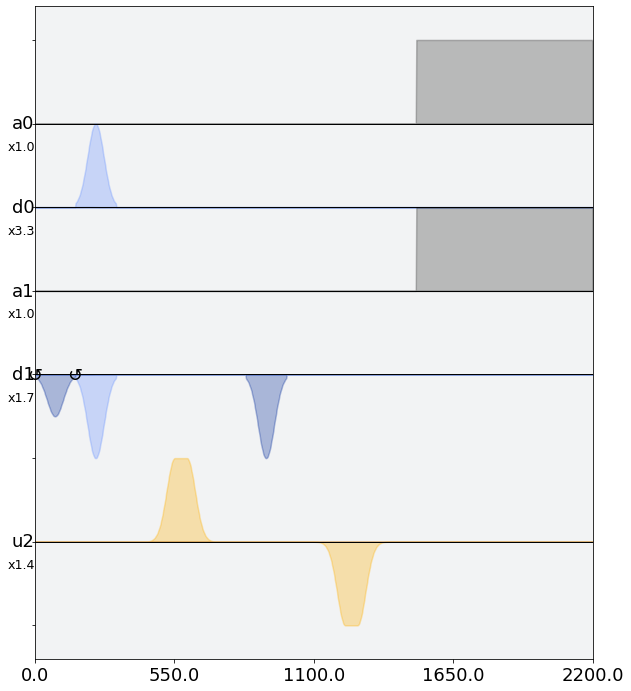

In [6]:
bell_sched.draw(table=False, plot_range=(0, 2200))

In [7]:
fig = bell_sched.draw(table=False, plot_range=(0, 2200))

In [8]:
fig.savefig('./figs/bell_sched.svg')

In [9]:
fig.savefig('./figs/bell_sched.png')

# QPT code example 

In [10]:
from qiskit import transpile, schedule, IBMQ
from qiskit.circuit import QuantumRegister, QuantumCircuit, Gate
from qiskit.pulse import Schedule, Play, ControlChannel, pulse_lib
from qiskit.pulse.pulse_lib import GaussianSquare
from qiskit.ignis.verification.tomography import process_tomography_circuits
from qiskit.test.mock import FakeAlmaden

# Unique name for instruction
gate_name = 'cr1'

# Pulse parameters determined during calibration
duration = 848
sigma = 32
risefall = 64
amp = 0.2

# Call your backend and get basis_gates and inst_map.
backend = FakeAlmaden()
config = backend.configuration()
defaults = backend.defaults()
basis_gates = config.basis_gates
inst_map = defaults.instruction_schedule_map

# Create the CR1 schedule.
cr1_pulse = GaussianSquare(duration, amp, sigma, risefall)
sched = Schedule()
sched += Play(cr1_pulse, ControlChannel(0))

# Add CR1 instruction to basis_gates and inst_map.
basis_gates += [gate_name]
inst_map.add(gate_name, [1, 0], sched)

# Create abstract quantum gate of pulse schedule.
cr1_gate = Gate(gate_name, 2, [])

# Create the QPT circuits.
qregs = QuantumRegister(config.n_qubits)
circuit = QuantumCircuit(qregs)
circuit.append(cr1_gate, qargs=[qregs[1], qregs[0]])
qpt_circuits = process_tomography_circuits(circuit, [qregs[0], qregs[1]])

# Create the QPT pulse schedules.
qpt_circuits = transpile(qpt_circuits, backend, basis_gates)
qpt_schedules = schedule(qpt_circuits, backend, inst_map)

# RB code example

In [11]:
from qiskit import transpile, schedule, IBMQ
from qiskit.circuit import QuantumCircuit, Gate
from qiskit.pulse import Schedule, Play, ControlChannel, pulse_lib
from qiskit.pulse.pulse_lib import GaussianSquare
from qiskit.ignis.verification.randomized_benchmarking import randomized_benchmarking_seq
from qiskit.test.mock import FakeAlmaden

# Unique name for instruction
gate_name = 'cr1'

# Randomized benchmark setup
n_seed = 5
n_clifford = [1, 21, 51, 101, 151]

# Pulse parameters determined during calibration
duration = 848
sigma = 32
risefall = 64
amp = 0.2

# Local rotation angles for CX(1,0) determined during optimization
local_rotations10 = [[1.45, 1.91, 1.64],
                     [1.56, 3.08, 2.45],
                     [-2.79, -3.05, -2.79],
                     [2.16, -3.12, 0.02]]

# Local rotation angles for CX(0,1) determined during optimization
local_rotations01 = [[-1.68, 3.04, 1.66],
                     [1.57, 2.28, -0.06],
                     [1.48, -0.46, 3.14],
                     [1.60, -3.14, 0.98]]

# Call your backend and get basis_gates and inst_map.
backend = FakeAlmaden()
config = backend.configuration()
defaults = backend.defaults()
basis_gates = config.basis_gates
inst_map = defaults.instruction_schedule_map

# Create the CR1 schedule.
cr1_pulse = GaussianSquare(duration, amp, sigma, risefall)
sched = Schedule()
sched += Play(cr1_pulse, ControlChannel(0))

# Add CR1 instruction to basis_gates and inst_map.
basis_gates += [gate_name]
inst_map.add(gate_name, [1, 0], sched)

# Create abstract quantum gate of pulse schedule.
cr1_gate = Gate(gate_name, 2, [])

# Build CX(1,0) schedule based on CR1 schedule.
qregs = QuantumRegister(config.n_qubits)
cnot10 = QuantumCircuit(qregs)
cnot10.u3(*local_rotations10[0], qregs[0])
cnot10.u3(*local_rotations10[1], qregs[1])
cnot10.append(cr1_gate, qargs=[qregs[1], qregs[0]])
cnot10.u3(*local_rotations10[2], qregs[0])
cnot10.u3(*local_rotations10[3], qregs[1])

cnot10 = transpile(cnot10, backend, basis_gates)
cnot_sched10 = schedule(cnot10, backend, inst_map)

# Build CX(0,1) schedule based on CR1 schedule.
qregs = QuantumRegister(config.n_qubits)
cnot01 = QuantumCircuit(qregs)
cnot01.u3(*local_rotations01[0], qregs[0])
cnot01.u3(*local_rotations01[1], qregs[1])
cnot01.append(cr1_gate, qargs=[qregs[1], qregs[0]])
cnot01.u3(*local_rotations01[2], qregs[0])
cnot01.u3(*local_rotations01[3], qregs[1])

cnot01 = transpile(cnot01, backend, basis_gates)
cnot_sched01 = schedule(cnot01, backend, inst_map)

# Overwrite the derault CNOT schedule in the inst_map.
inst_map.add('cx', [1, 0], cnot_sched10)
inst_map.add('cx', [0, 1], cnot_sched01)

# Create standard randomized benchmark circuits for 5 seeds
rb_circuits_seeds, _ = randomized_benchmarking_seq(n_seed, n_clifford, [[0, 1]])

# Convert randomized benchmark experiment into pulse schedules.
rb_schedules_seeds = []
for rb_circuits_seed in rb_circuits_seeds:
    rb_circuits_seed = transpile(rb_circuits_seed, backend, basis_gates)
    rb_schedules_seed = schedule(rb_circuits_seed, backend, inst_map)    
    rb_schedules_seeds.append(rb_schedules_seed)

In [12]:
rb_circuits_seeds[0][0].draw(fold=-1)

┌─────┐┌───┐ ░ ┌───┐┌───┐     ┌─┐   
qr_0: ──■──┤ Sdg ├┤ H ├─░─┤ H ├┤ S ├──■──┤M├───
      ┌─┴─┐└┬───┬┘└───┘ ░ ├───┤└───┘┌─┴─┐└╥┘┌─┐
qr_1: ┤ X ├─┤ X ├───────░─┤ X ├─────┤ X ├─╫─┤M├
      └───┘ └───┘       ░ └───┘     └───┘ ║ └╥┘
cr_0: ════════════════════════════════════╩══╬═
                                             ║ 
cr_1: ═══════════════════════════════════════╩═

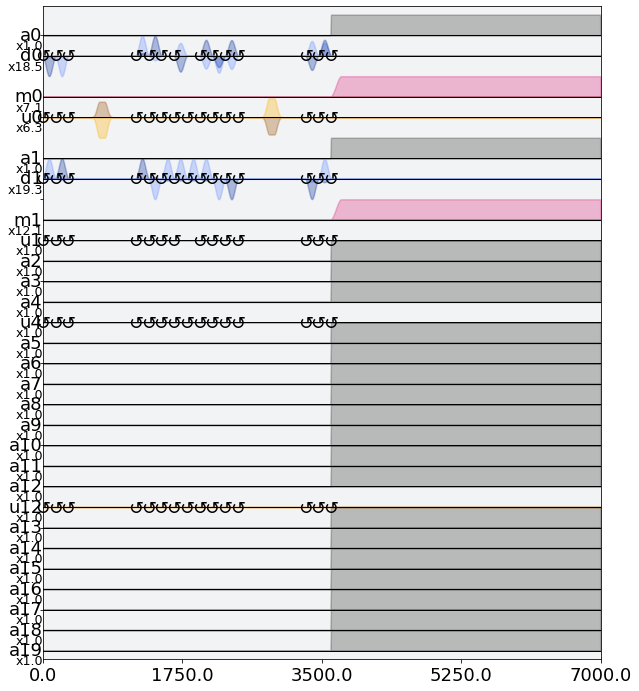

In [13]:
rb_schedules_seeds[0][0].draw(table=False, plot_range=(0, 7000))

In [14]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright